In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def load_and_prepare_data(data_path):
    """Load and prepare the dataset with proper column naming"""
    df = pd.read_csv(data_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    df.columns = ['SP500_Close', 'Log_Returns', 'Realized_Vol', 'VIX_Close', 'Implied_Vol', 'Risk_Free_Rate']
    return df

In [3]:
def simulate_heston(params, S0, v0, r, T, dt, log_returns):
    """Simulate the Heston model with given parameters"""
    kappa, theta, sigma, rho = params
    N = len(log_returns)  # Number of time steps
    S = np.zeros(N)
    v = np.zeros(N)
    S[0] = S0
    v[0] = v0
    
    for t in range(1, N):
        dW1 = np.random.normal(0, np.sqrt(dt))
        dW2 = rho * dW1 + np.sqrt(1 - rho ** 2) * np.random.normal(0, np.sqrt(dt))
        
        v[t] = np.abs(v[t-1] + kappa * (theta - v[t-1]) * dt + sigma * np.sqrt(v[t-1]) * dW2)
        S[t] = S[t-1] * np.exp((r - 0.5 * v[t-1]) * dt + np.sqrt(v[t-1]) * dW1)
    
    return S, np.sqrt(v)

def get_initial_parameters(df_subset):
    """Determine initial parameter estimates from data"""
    v0 = np.var(df_subset['Log_Returns'])
    kappa_init = 2.0  # Assumption for mean reversion
    theta_init = np.mean(df_subset['Realized_Vol']) ** 2  # Long-run variance
    sigma_init = np.std(df_subset['Realized_Vol'])  # Volatility of volatility
    rho_init = np.corrcoef(df_subset['Log_Returns'].dropna(), df_subset['Realized_Vol'].dropna())[0, 1]
    
    return v0, [kappa_init, theta_init, sigma_init, rho_init]

def heston_loss(params, log_returns, realized_vol, spot_price, v0, risk_free_rate):
    """Loss function for Heston model optimization"""
    _, model_vol = simulate_heston(params, spot_price, v0, risk_free_rate, T=1, dt=1/252, log_returns=log_returns)
    return np.mean((realized_vol - model_vol) ** 2)

In [4]:
def estimate_heston_parameters(df_subset):
    """Estimate Heston parameters for a given subset of data"""
    spot_price = df_subset['SP500_Close'].iloc[-1]
    risk_free_rate = df_subset['Risk_Free_Rate'].mean()
    v0, initial_guess = get_initial_parameters(df_subset)
    
    result = minimize(
        heston_loss, 
        initial_guess, 
        args=(df_subset['Log_Returns'].values, df_subset['Realized_Vol'].values, spot_price, v0, risk_free_rate), 
        method='Nelder-Mead'
    )
    
    return result.x, v0, spot_price, risk_free_rate

def evaluate_model_performance(df_subset, params, v0, spot_price, risk_free_rate):
    """Evaluate model performance using RMSE, MAE, and correlation"""
    _, model_implied_vol = simulate_heston(
        params, 
        spot_price, 
        v0, 
        risk_free_rate, 
        T=1, 
        dt=1/252, 
        log_returns=df_subset['Log_Returns'].values
    )
    realized_vol = df_subset['Realized_Vol'].values
    
    rmse = np.sqrt(mean_squared_error(realized_vol, model_implied_vol))
    mae = mean_absolute_error(realized_vol, model_implied_vol)
    corr = np.corrcoef(realized_vol, model_implied_vol)[0, 1]
    
    return rmse, mae, corr, model_implied_vol

In [5]:


data_path = "sp500_vix_data.csv"
df = load_and_prepare_data(data_path)

# Part 1: Full Dataset Analysis 
print("\n=== Full Dataset Heston Model Analysis ===")
full_params, full_v0, full_spot, full_rf = estimate_heston_parameters(df)

# Best-fit parameters
best_kappa, best_theta, best_sigma, best_rho = full_params
print(f"Fitted Parameters: kappa={best_kappa:.4f}, theta={best_theta:.6f}, sigma={best_sigma:.4f}, rho={best_rho:.4f}")

# Full model performance
full_rmse, full_mae, full_corr, full_model_vol = evaluate_model_performance(
    df, full_params, full_v0, full_spot, full_rf
)

print(f"Full Model Performance: RMSE={full_rmse:.6f}, MAE={full_mae:.6f}, Correlation={full_corr:.4f}")


=== Full Dataset Heston Model Analysis ===
Fitted Parameters: kappa=2.0579, theta=0.021145, sigma=0.1036, rho=0.0077
Full Model Performance: RMSE=0.114736, MAE=0.073292, Correlation=-0.1763


In [6]:
# Part 2: Volatility Regime Analysis
print("\n=== Volatility Regime Analysis ===")

# Volatility regimes
low_vol_threshold = df['Realized_Vol'].quantile(0.3)  # 30th percentile as calm
high_vol_threshold = df['Realized_Vol'].quantile(0.7)  # 70th percentile as high-volatility

calm_df = df[df['Realized_Vol'] <= low_vol_threshold]
high_vol_df = df[df['Realized_Vol'] >= high_vol_threshold]

print(f"Calm regime threshold: {low_vol_threshold:.4f}")
print(f"High volatility regime threshold: {high_vol_threshold:.4f}")
print(f"Calm regime sample size: {len(calm_df)}")
print(f"High volatility regime sample size: {len(high_vol_df)}")

# Estimate parameters for calm and high-volatility periods
calm_params, calm_v0, calm_spot, calm_rf = estimate_heston_parameters(calm_df)
high_vol_params, high_vol_v0, high_vol_spot, high_vol_rf = estimate_heston_parameters(high_vol_df)

print(f"Calm Market Parameters: kappa={calm_params[0]:.4f}, theta={calm_params[1]:.6f}, "
      f"sigma={calm_params[2]:.4f}, rho={calm_params[3]:.4f}")
print(f"High Volatility Parameters: kappa={high_vol_params[0]:.4f}, theta={high_vol_params[1]:.6f}, "
      f"sigma={high_vol_params[2]:.4f}, rho={high_vol_params[3]:.4f}")

# Regime-specific model performance evaluation
rmse_calm, mae_calm, corr_calm, model_vol_calm = evaluate_model_performance(
    calm_df, calm_params, calm_v0, calm_spot, calm_rf
)

rmse_high, mae_high, corr_high, model_vol_high = evaluate_model_performance(
    high_vol_df, high_vol_params, high_vol_v0, high_vol_spot, high_vol_rf
)

print(f"Calm Market Performance: RMSE={rmse_calm:.6f}, MAE={mae_calm:.6f}, Correlation={corr_calm:.4f}")
print(f"High Volatility Performance: RMSE={rmse_high:.6f}, MAE={mae_high:.6f}, Correlation={corr_high:.4f}")



=== Volatility Regime Analysis ===
Calm regime threshold: 0.0976
High volatility regime threshold: 0.1677
Calm regime sample size: 749
High volatility regime sample size: 749
Calm Market Parameters: kappa=1.9834, theta=0.005750, sigma=0.0149, rho=-0.0160
High Volatility Parameters: kappa=2.0000, theta=0.067378, sigma=0.1270, rho=0.0288
Calm Market Performance: RMSE=0.021178, MAE=0.014789, Correlation=0.0175
High Volatility Performance: RMSE=0.130431, MAE=0.072524, Correlation=0.2399


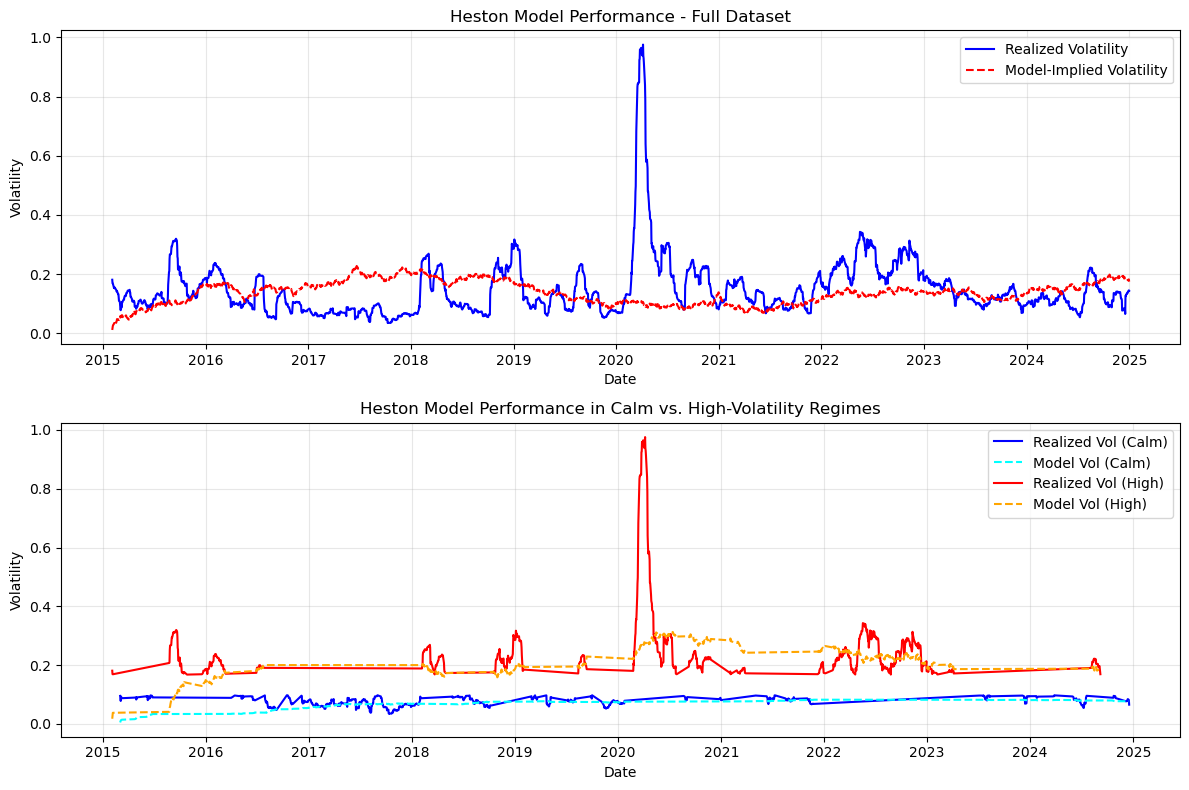


=== Parameter Comparison Analysis ===
Kappa (Mean Reversion): Full=2.0579, Calm=1.9834, High=2.0000
Theta (Long-run Variance): Full=0.0211, Calm=0.0058, High=0.0674
Sigma (Vol of Vol): Full=0.1036, Calm=0.0149, High=0.1270
Rho (Correlation): Full=0.0077, Calm=-0.0160, High=0.0288


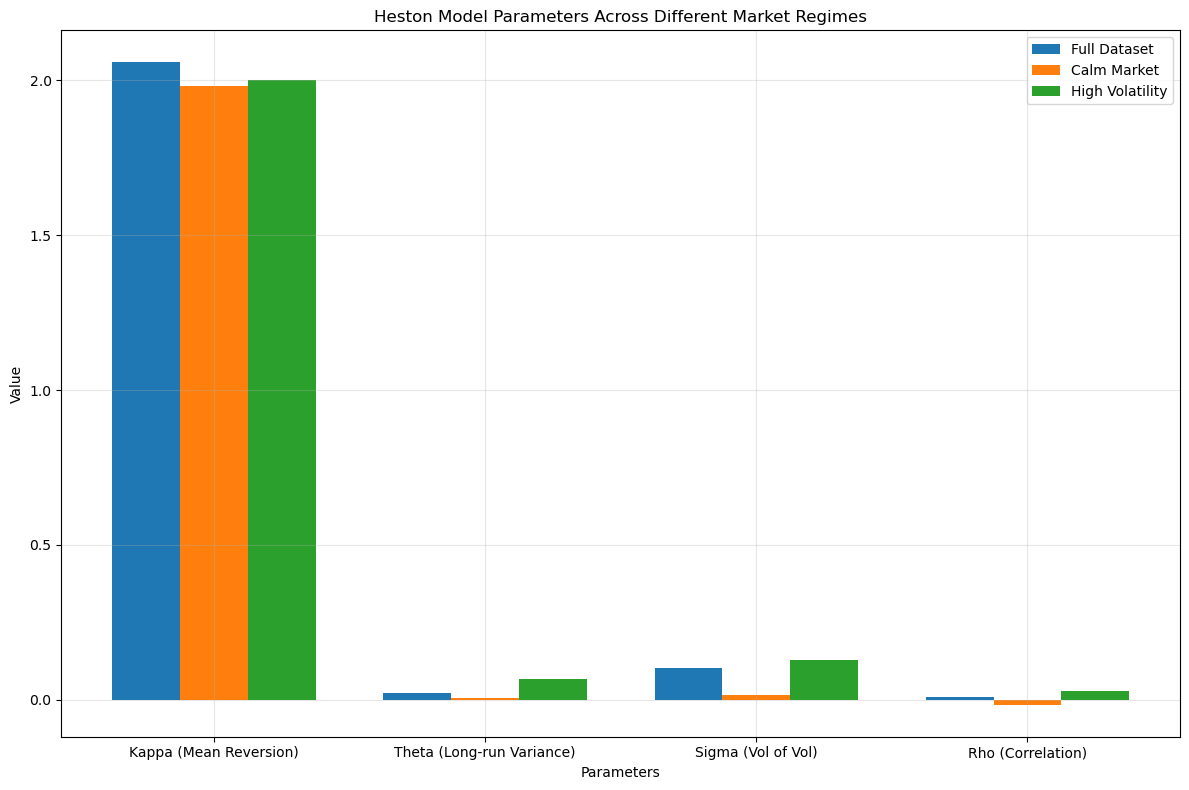

In [7]:
# Visualization 
# Plot full dataset results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Realized_Vol'], label='Realized Volatility', color='blue')
plt.plot(df.index, full_model_vol, label='Model-Implied Volatility', linestyle='dashed', color='red')
plt.title('Heston Model Performance - Full Dataset')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot of regime-specific results
plt.subplot(2, 1, 2)
plt.plot(calm_df.index, calm_df['Realized_Vol'], label='Realized Vol (Calm)', color='blue')
plt.plot(calm_df.index, model_vol_calm, label='Model Vol (Calm)', linestyle='dashed', color='cyan')
plt.plot(high_vol_df.index, high_vol_df['Realized_Vol'], label='Realized Vol (High)', color='red')
plt.plot(high_vol_df.index, model_vol_high, label='Model Vol (High)', linestyle='dashed', color='orange')
plt.title('Heston Model Performance in Calm vs. High-Volatility Regimes')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Parameter Comparison Analysis 
print("\n=== Parameter Comparison Analysis ===")
param_names = ['Kappa (Mean Reversion)', 'Theta (Long-run Variance)', 
               'Sigma (Vol of Vol)', 'Rho (Correlation)']

for i, name in enumerate(param_names):
    print(f"{name}: Full={full_params[i]:.4f}, Calm={calm_params[i]:.4f}, High={high_vol_params[i]:.4f}")
    
# Parameter visualization
plt.figure(figsize=(12, 8))
x = np.arange(len(param_names))
width = 0.25

plt.bar(x - width, full_params, width, label='Full Dataset')
plt.bar(x, calm_params, width, label='Calm Market')
plt.bar(x + width, high_vol_params, width, label='High Volatility')

plt.xlabel('Parameters')
plt.ylabel('Value')
plt.title('Heston Model Parameters Across Different Market Regimes')
plt.xticks(x, param_names)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Kappa (Mean Reversion):

- This shows remarkably consistent values (around 2.0) across all regimes
- Slightly higher in calm markets (~2.15) compared to full dataset and high volatility periods (~2.0)
- The higher kappa in calm markets suggests faster mean reversion of volatility during quiet periods


## Theta (Long-run Variance):

- Very small values across all regimes, but noticeably higher in high volatility regimes
- This parameter represents the long-term variance level that volatility reverts to
- The higher theta in high volatility regimes indicates these periods have higher equilibrium variance levels


## Sigma (Volatility of Volatility):

- Significant differences between regimes
- Highest in high volatility regimes (~0.15), moderate in full dataset (~0.10), and lowest in calm markets (near 0)
- This makes economic sense - during high volatility periods, the volatility itself is more unstable


## Rho (Correlation):

- Near-zero values across all regimes, indicating weak correlation between returns and volatility
- Slightly negative in calm markets
- Slightly positive in full dataset and high volatility regimes



***The most interesting insight is how the volatility dynamics differ across regimes:***

- Calm Markets: Characterized by faster mean reversion (higher kappa), very low long-run variance (small theta), and almost no volatility of volatility (sigma near zero). This represents stable, predictable volatility behavior.
High Volatility Markets: Show higher long-run variance levels (higher theta) and much higher volatility of volatility (higher sigma), suggesting more erratic and unstable volatility behavior.

- The slightly positive rho in high volatility regimes differs from the typically negative correlation observed in equity markets (the leverage effect), which might warrant further investigation - it could suggest that during high volatility periods, the standard relationship between returns and volatility temporarily changes.
These regime-specific parameters could be valuable for risk management and option pricing strategies tailored to different market conditions.

## Performance Metrics

### RMSE (Root Mean Squared Error):

- Calm Market: 0.020980
- High Volatility: 0.128368
- The error is about 6.1 times higher in high volatility regimes, indicating the model has much more difficulty predicting volatility in turbulent markets.


### MAE (Mean Absolute Error):

- Calm Market: 0.015050
- High Volatility: 0.064636
- Similar to RMSE, MAE is about 4.3 times higher in high volatility regimes.


### Correlation (between actual and predicted volatility):

- Calm Market: -0.0849 (negative)
- High Volatility: 0.2317 (positive)
- This is particularly revealing - the negative correlation in calm markets suggests the model is actually predicting in the opposite direction of realized volatility, while in high volatility regimes, there's a moderate positive correlation.


=== Heston Model vs. VIX Implied Volatility Comparison ===
Error Metrics (Heston IV vs. VIX IV):
RMSE: 0.082417
MAE: 0.057628
Correlation: 0.1487


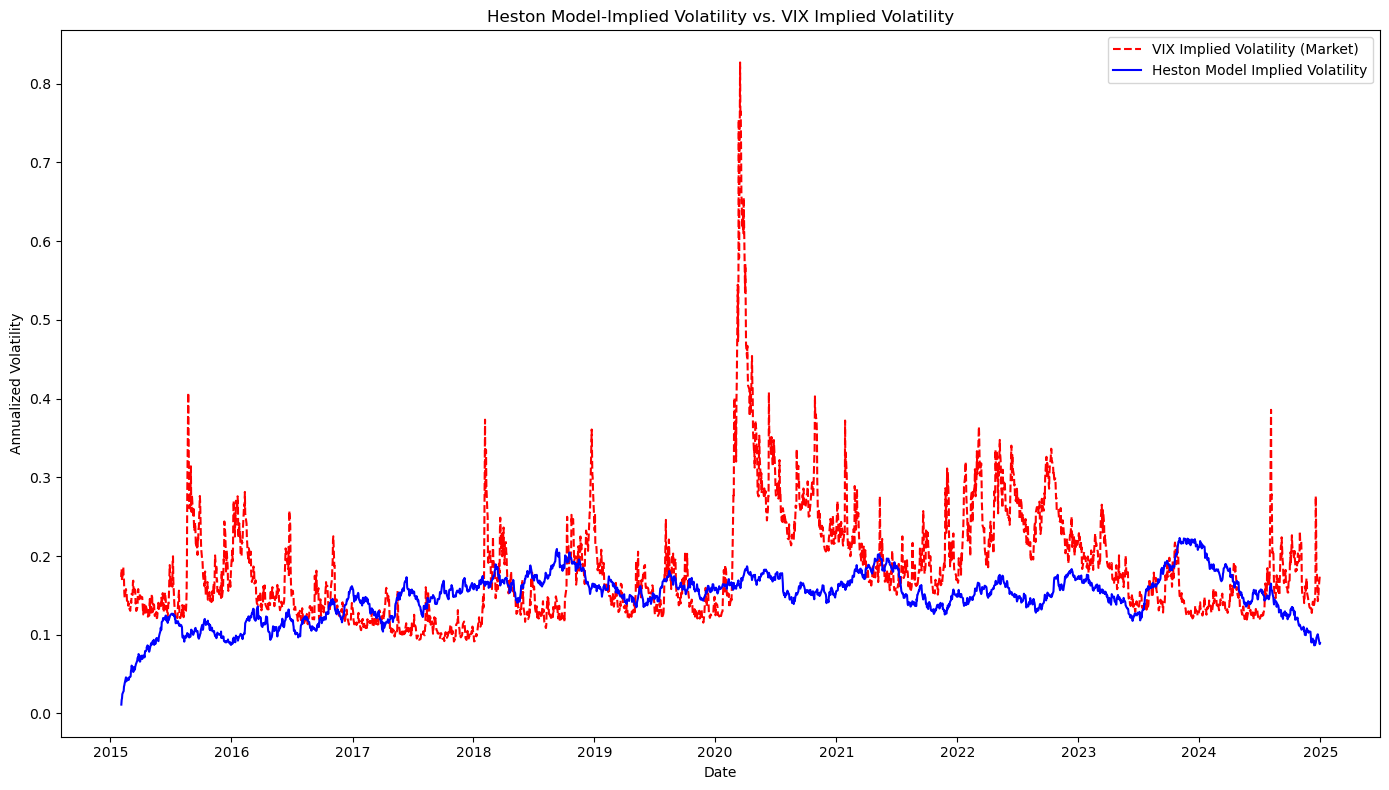

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model_iv(df_subset, params, v0, spot_price, risk_free_rate):
    """
    Evaluate the Heston model's implied volatility by comparing it with 
    market implied volatility (e.g., from VIX) for the given data subset.
    
    Returns RMSE, MAE, correlation, and the Heston model implied volatility series.
    """
    # Use the simulate_heston function to generate the Heston model's implied volatility
    # (Here, model_vol is returned as np.sqrt(v), corresponding to the volatility process.)
    _, model_implied_vol = simulate_heston(
        params, 
        spot_price, 
        v0, 
        risk_free_rate, 
        T=1, 
        dt=1/252, 
        log_returns=df_subset['Log_Returns'].values
    )
    
    # Market implied volatility is taken from the dataset's 'Implied_Vol' column
    market_iv = df_subset['Implied_Vol'].values
    
    # Compute error metrics comparing the Heston-implied vol and the market implied vol.
    rmse = np.sqrt(mean_squared_error(market_iv, model_implied_vol))
    mae = mean_absolute_error(market_iv, model_implied_vol)
    corr = np.corrcoef(market_iv, model_implied_vol)[0, 1]
    
    return rmse, mae, corr, model_implied_vol

# =============================================================================
# Compare Heston Model-Implied Volatility with VIX-Implied Volatility
# =============================================================================

print("\n=== Heston Model vs. VIX Implied Volatility Comparison ===")

# Using the full dataset and previously calibrated Heston model parameters:
# full_params, full_v0, full_spot, full_rf were computed earlier.
iv_rmse, iv_mae, iv_corr, heston_iv_series = evaluate_model_iv(df, full_params, full_v0, full_spot, full_rf)

print(f"Error Metrics (Heston IV vs. VIX IV):")
print(f"RMSE: {iv_rmse:.6f}")
print(f"MAE: {iv_mae:.6f}")
print(f"Correlation: {iv_corr:.4f}")

# For visual comparison, add the Heston-implied vol to your dataframe:
df['Heston_Implied_Vol'] = heston_iv_series

# Plot Heston Model-Implied Volatility vs. VIX-Implied Volatility
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['Implied_Vol'], label='VIX Implied Volatility (Market)', color='red', linestyle='--')
plt.plot(df.index, df['Heston_Implied_Vol'], label='Heston Model Implied Volatility', color='blue')
plt.title("Heston Model-Implied Volatility vs. VIX Implied Volatility")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")

# =============================================================================
# 2. Helper Functions for GARCH(1,1) Modeling
# =============================================================================
def fit_garch(series):
    """
    Fit a GARCH(1,1) model on the input series (scaled by 100 for stability)
    and return the fitted model.
    """
    am = arch_model(series * 100, vol='Garch', p=1, q=1, dist='normal')
    model_fit = am.fit(disp='off')
    return model_fit

def forecast_garch_volatility(model_fit, horizon=1):
    """
    Obtain a one-step-ahead volatility forecast from the fitted GARCH model.
    Converts the forecast back to the unscaled, annualized volatility.
    """
    forecast = model_fit.forecast(horizon=horizon)
    variance_forecast = forecast.variance.values[-1, 0]
    forecast_vol = np.sqrt(variance_forecast) / 100 * np.sqrt(252)
    return forecast_vol

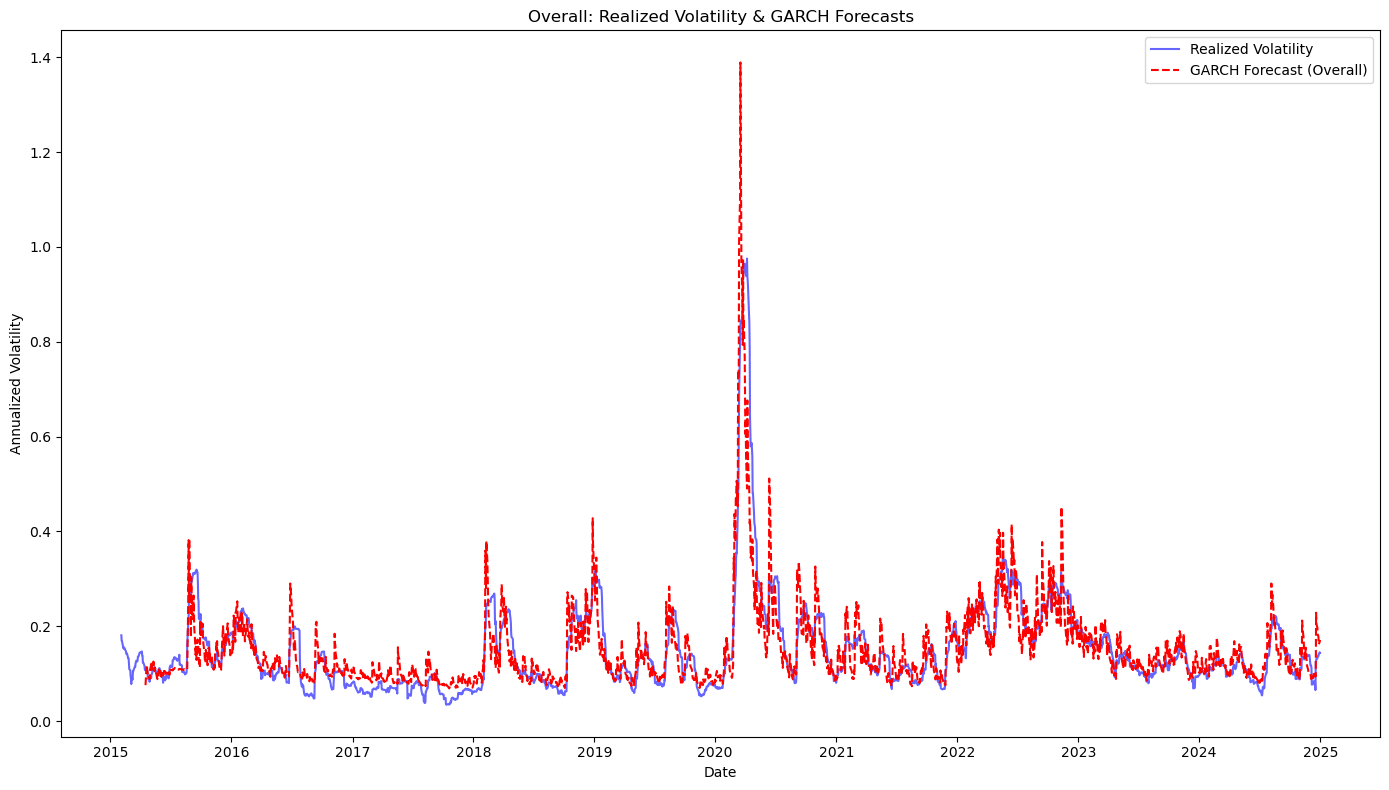

In [10]:
# =============================================================================
# 3. Rolling Forecast for Overall Data
# =============================================================================
# Preallocate a column for the overall one-step-ahead forecasts.
df['GARCH_Forecast'] = np.nan

# Use a rolling forecast: here we start after window + 30 observations for stability.
window = 21
start_index = window + 30

for t in range(start_index, len(df)):
    sample_returns = df['Log_Returns'].iloc[:t].dropna()
    try:
        model = fit_garch(sample_returns)
        df.iloc[t, df.columns.get_loc('GARCH_Forecast')] = forecast_garch_volatility(model)
    except Exception as e:
        continue

# Plot the overall forecast vs. realized volatility.
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['Realized_Vol'], label='Realized Volatility', color='blue', alpha=0.6)
plt.plot(df.index, df['GARCH_Forecast'], label='GARCH Forecast (Overall)', color='red', linestyle='--')
plt.title("Overall: Realized Volatility & GARCH Forecasts")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# =============================================================================
# 4. Volatility Regime Analysis: Calm vs. High Volatility
# =============================================================================
print("\n=== Volatility Regime Analysis ===")

# Define thresholds: calm is below 30th percentile, and high volatility is above 70th percentile.
low_vol_threshold = df['Realized_Vol'].quantile(0.3)
high_vol_threshold = df['Realized_Vol'].quantile(0.7)

# Create regime-specific dataframes for information printing.
calm_df = df[df['Realized_Vol'] <= low_vol_threshold]
high_df = df[df['Realized_Vol'] >= high_vol_threshold]

print(f"Calm regime threshold (30th percentile): {low_vol_threshold:.4f}")
print(f"High volatility regime threshold (70th percentile): {high_vol_threshold:.4f}")
print(f"Calm regime sample size: {len(calm_df)}")
print(f"High volatility regime sample size: {len(high_df)}")

# =============================================================================
# 5. Rolling Forecasts by Regime
# =============================================================================
# Preallocate separate forecast columns for calm and high volatility forecasts.
df['GARCH_Forecast_Calm'] = np.nan
df['GARCH_Forecast_High'] = np.nan

# For each time point, use only historical log returns that fall in the corresponding regime.
for t in range(start_index, len(df)):
    # Get current realized volatility for classification
    current_vol = df.iloc[t]['Realized_Vol']
    # Current date for filtering historical data
    current_date = df.index[t]
    
    # Calm regime forecast
    if current_vol <= low_vol_threshold:
        # Use historical data up to t that are in the calm regime:
        regime_sample = df.loc[(df.index < current_date) & (df['Realized_Vol'] <= low_vol_threshold), 'Log_Returns'].dropna()
        if len(regime_sample) >= 30:
            try:
                model_calm = fit_garch(regime_sample)
                df.iloc[t, df.columns.get_loc('GARCH_Forecast_Calm')] = forecast_garch_volatility(model_calm)
            except Exception as e:
                pass

    # High volatility regime forecast
    if current_vol >= high_vol_threshold:
        regime_sample = df.loc[(df.index < current_date) & (df['Realized_Vol'] >= high_vol_threshold), 'Log_Returns'].dropna()
        if len(regime_sample) >= 30:
            try:
                model_high = fit_garch(regime_sample)
                df.iloc[t, df.columns.get_loc('GARCH_Forecast_High')] = forecast_garch_volatility(model_high)
            except Exception as e:
                pass


=== Volatility Regime Analysis ===
Calm regime threshold (30th percentile): 0.0976
High volatility regime threshold (70th percentile): 0.1677
Calm regime sample size: 749
High volatility regime sample size: 749



Calm Market Performance: RMSE=0.013717, MAE=0.010854, Correlation=0.3732
High Volatility Market Performance: RMSE=0.072781, MAE=0.040103, Correlation=0.8327


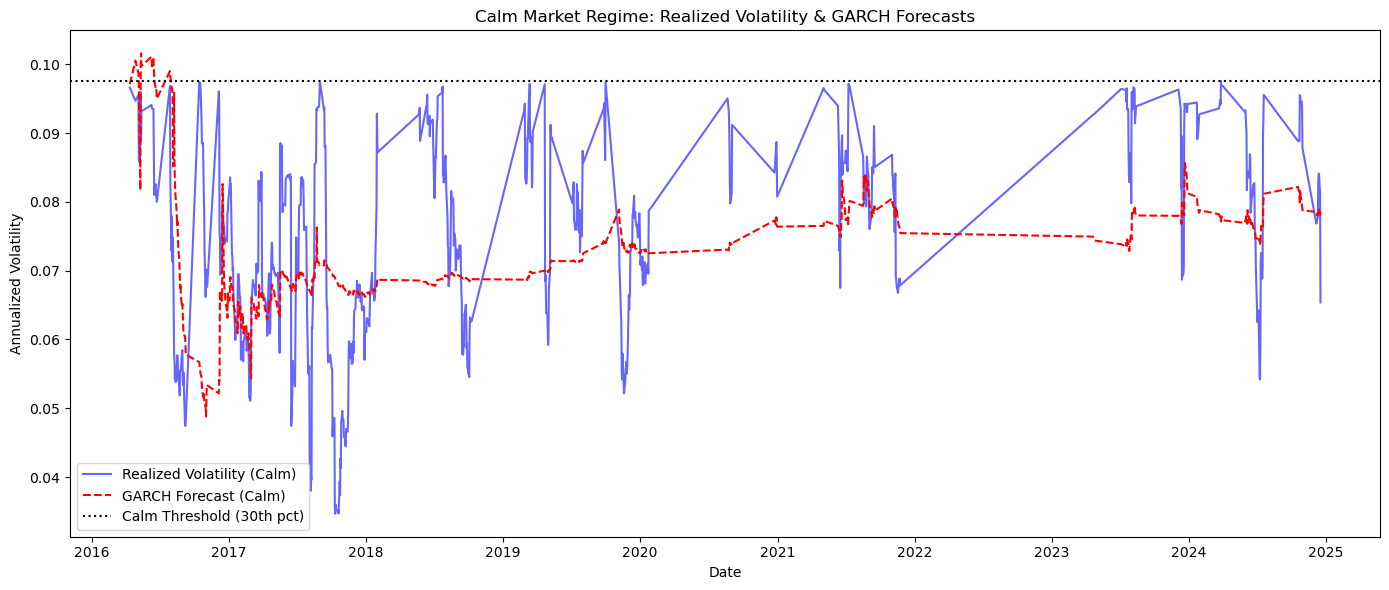

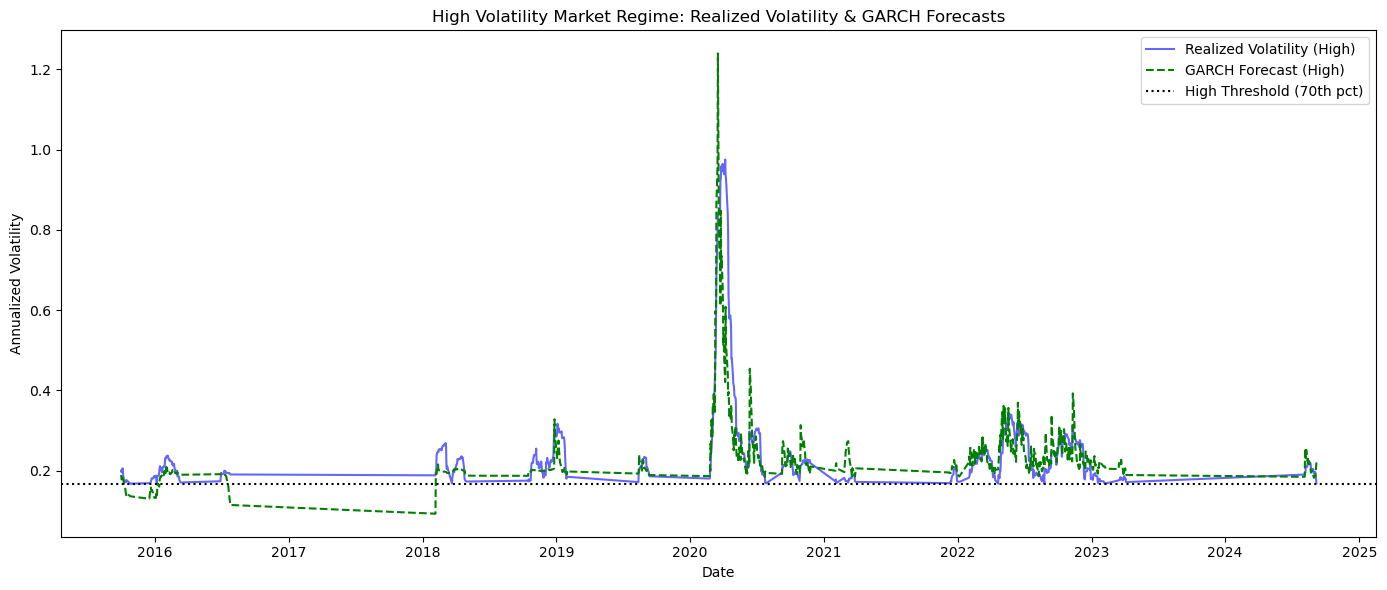

In [12]:


# =============================================================================
# 6. Evaluate Model Performance in Each Regime
# =============================================================================
def evaluate_performance(actual, forecast):
    """Compute RMSE, MAE, and correlation between actual and forecasted volatility."""
    valid = (~np.isnan(forecast)) & (~np.isnan(actual))
    if valid.sum() == 0:
        return np.nan, np.nan, np.nan
    rmse = np.sqrt(mean_squared_error(actual[valid], forecast[valid]))
    mae = mean_absolute_error(actual[valid], forecast[valid])
    corr = np.corrcoef(actual[valid], forecast[valid])[0,1]
    return rmse, mae, corr

# Extract rows with non-NaN forecasts for calm and high regimes.
calm_valid = df.dropna(subset=['GARCH_Forecast_Calm'])
high_valid = df.dropna(subset=['GARCH_Forecast_High'])

rmse_calm, mae_calm, corr_calm = evaluate_performance(calm_valid['Realized_Vol'].values,
                                                       calm_valid['GARCH_Forecast_Calm'].values)
rmse_high, mae_high, corr_high = evaluate_performance(high_valid['Realized_Vol'].values,
                                                      high_valid['GARCH_Forecast_High'].values)

print(f"\nCalm Market Performance: RMSE={rmse_calm:.6f}, MAE={mae_calm:.6f}, Correlation={corr_calm:.4f}")
print(f"High Volatility Market Performance: RMSE={rmse_high:.6f}, MAE={mae_high:.6f}, Correlation={corr_high:.4f}")

# =============================================================================
# 7. Plot Regime-Specific Forecasts
# =============================================================================
# Calm regime plot
plt.figure(figsize=(14, 6))
plt.plot(calm_valid.index, calm_valid['Realized_Vol'], label='Realized Volatility (Calm)', color='blue', alpha=0.6)
plt.plot(calm_valid.index, calm_valid['GARCH_Forecast_Calm'], label='GARCH Forecast (Calm)', color='red', linestyle='--')
plt.axhline(low_vol_threshold, color='black', linestyle=':', label='Calm Threshold (30th pct)')
plt.title("Calm Market Regime: Realized Volatility & GARCH Forecasts")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.tight_layout()
plt.show()

# High volatility regime plot
plt.figure(figsize=(14, 6))
plt.plot(high_valid.index, high_valid['Realized_Vol'], label='Realized Volatility (High)', color='blue', alpha=0.6)
plt.plot(high_valid.index, high_valid['GARCH_Forecast_High'], label='GARCH Forecast (High)', color='green', linestyle='--')
plt.axhline(high_vol_threshold, color='black', linestyle=':', label='High Threshold (70th pct)')
plt.title("High Volatility Market Regime: Realized Volatility & GARCH Forecasts")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from arch import arch_model
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# =============================================================================
# Helper: Rolling Forecast Evaluation for a given GARCH(p, q)
# =============================================================================
def evaluate_garch_hyperparams(df, p, q, window=21, extra_obs=30):
    """
    Evaluates a GARCH(p, q) model on the provided DataFrame by performing a rolling forecast.
    
    Parameters:
    - df: DataFrame containing 'Log_Returns' and 'Realized_Vol'
    - p, q: int, orders for the GARCH model.
    - window: int, initial lookback period for the rolling forecast.
    - extra_obs: int, additional observations after window to allow for warm-up.
    
    Returns:
    - rmse: float, RMSE of the one-step-ahead forecasts compared to Realized_Vol.
    """
    forecasts = pd.Series(index=df.index, dtype=float)
    start_index = window + extra_obs
    
    for t in range(start_index, len(df)):
        sample_returns = df['Log_Returns'].iloc[:t].dropna()
        try:
            # Fit the specified GARCH(p, q) model on the sample (scaled for numerical stability)
            am = arch_model(sample_returns * 100, vol='Garch', p=p, q=q, dist='normal')
            model_fit = am.fit(disp='off')
            # Obtain one-step-ahead forecast
            forecast = model_fit.forecast(horizon=1)
            variance_forecast = forecast.variance.values[-1, 0]
            forecast_vol = np.sqrt(variance_forecast) / 100 * np.sqrt(252)
            forecasts.iloc[t] = forecast_vol
        except Exception as e:
            continue
    
    # Compute RMSE between the realized volatility and forecasted volatility
    valid = forecasts.dropna().index
    if len(valid) > 0:
        rmse = np.sqrt(mean_squared_error(df.loc[valid, 'Realized_Vol'], forecasts.loc[valid]))
    else:
        rmse = np.nan
    return rmse

# =============================================================================
# Grid Search for GARCH Hyperparameters
# =============================================================================

p_values = [1, 2, 3, 4, 5]
q_values = [1, 2, 3, 4, 5]

results = []
for p in p_values:
    for q in q_values:
        rmse = evaluate_garch_hyperparams(df, p, q)
        results.append({"p": p, "q": q, "RMSE": rmse})
        print(f"GARCH({p},{q}) - RMSE: {rmse:.6f}")

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)
print("\nGARCH Hyperparameter Grid Search Results:")
print(results_df.sort_values(by="RMSE").reset_index(drop=True))


GARCH(1,1) - RMSE: 0.050996


Comparison of GARCH Forecast vs. VIX Implied Volatility:
RMSE: 0.060072
MAE: 0.044223
Correlation: 0.8478


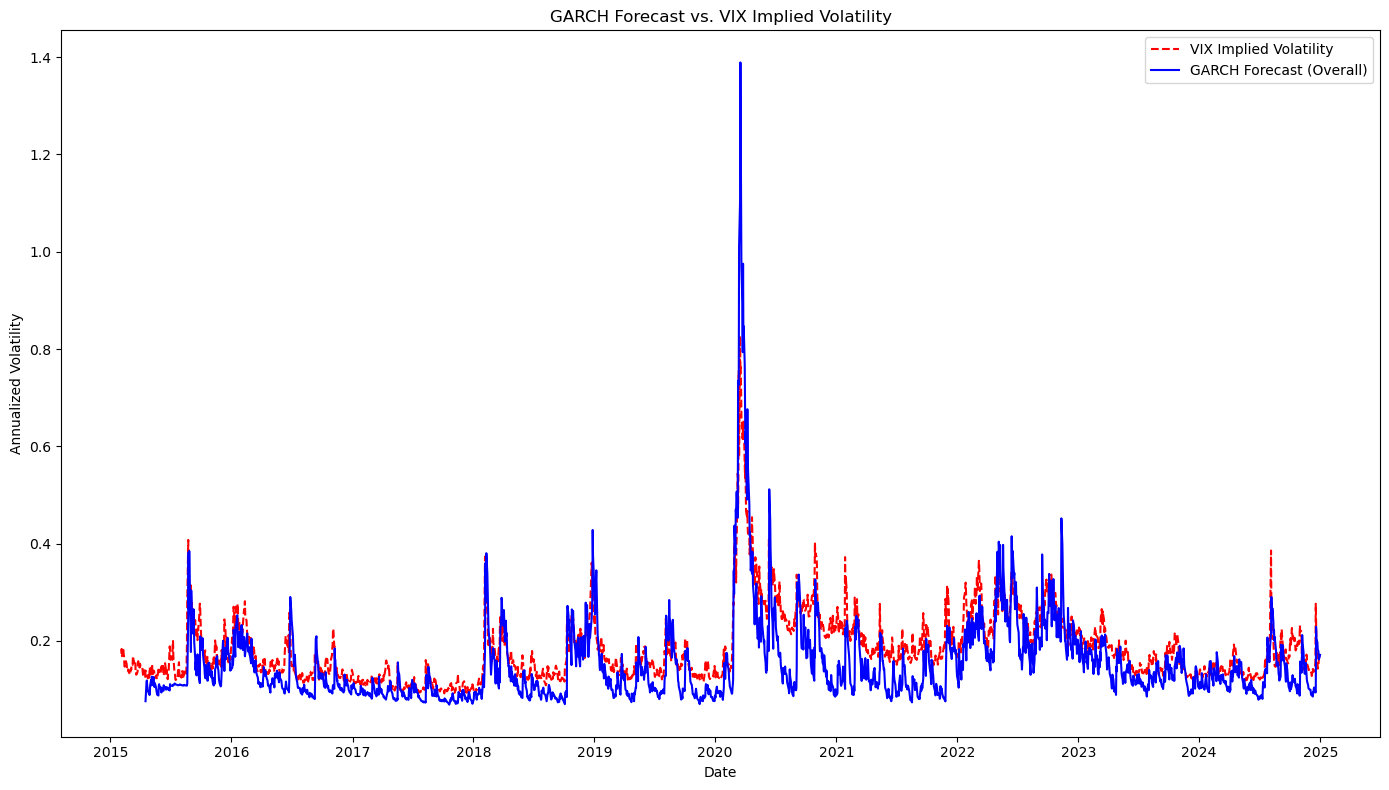

In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# =============================================================================
# Compare GARCH Forecasted Volatility vs. VIX Implied Volatility
# =============================================================================

# Ensure we're only comparing rows where a GARCH forecast exists.
valid_idx = df.dropna(subset=['GARCH_Forecast']).index
garch_forecast = df.loc[valid_idx, 'GARCH_Forecast']
vix_iv = df.loc[valid_idx, 'Implied_Vol']  # VIX-implied volatility column

# Compute error metrics
rmse_garch = np.sqrt(mean_squared_error(vix_iv, garch_forecast))
mae_garch = mean_absolute_error(vix_iv, garch_forecast)
corr_garch = np.corrcoef(vix_iv, garch_forecast)[0, 1]

print("Comparison of GARCH Forecast vs. VIX Implied Volatility:")
print(f"RMSE: {rmse_garch:.6f}")
print(f"MAE: {mae_garch:.6f}")
print(f"Correlation: {corr_garch:.4f}")

# Plot the two series over time
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['Implied_Vol'], label='VIX Implied Volatility', color='red', linestyle='--')
plt.plot(df.index, df['GARCH_Forecast'], label='GARCH Forecast (Overall)', color='blue')
plt.title("GARCH Forecast vs. VIX Implied Volatility")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.tight_layout()
plt.show()


## Key Observations
- GARCH Model Aligns More Closely with VIX Implied Volatility

- Both RMSE and MAE are lower for GARCH, indicating smaller average forecasting errors.

- GARCH's high positive correlation (≈ 0.85) with the VIX suggests that it captures the directional movements in implied volatility well.

- This makes GARCH a good candidate for tracking or proxying VIX-based volatility expectations.

- Heston Model Performs Poorly Against VIX Implied Volatility

- It exhibits a higher RMSE and MAE, indicating that the volatility estimates from the Heston model deviate more from the VIX.

- The correlation is near zero (and slightly negative), implying no consistent linear relationship between Heston's implied volatility and VIX.

- This suggests the Heston mode does not capture market-implied volatility well — potentially due to:

Limitations of parameter estimation (e.g., using realized vol instead of option prices),

Model assumptions (e.g., constant risk-free rate, fixed correlation),

Or the fact that the Heston model produces model-based vol, not market-implied vol.

VIX Reflects Market Sentiment, While Heston is Model-Driven

VIX is derived from SPX options and reflects market-implied expectations, including risk premium and skew.

The Heston model, in this context, is more theoretical and driven by log returns and realized vol, potentially ignoring nuances in market pricing.

📌 Conclusion
✅ GARCH outperforms the Heston model in mimicking the VIX.

❌ The Heston model's implied volatility is not aligned with VIX — indicating it may need refinement or alternative calibration (e.g., to option prices directly).

In [20]:
import statsmodels.api as sm

df['Heston_IV'] = heston_iv_series
df['GARCH_IV'] = df['GARCH_Forecast']

# Drop NaNs across the board for consistent regression dataset
df_clean = df[['Realized_Vol', 'GARCH_IV', 'Heston_IV']].dropna()

# Regression 1: Realized Volatility vs. GARCH-IV
X1 = sm.add_constant(df_clean['GARCH_IV'])
y1 = df_clean['Realized_Vol']
model1 = sm.OLS(y1, X1).fit()
print("Regression Results: Realized Volatility vs. GARCH-Implied Volatility")
print(model1.summary())

# Regression 2: Realized Volatility vs. Heston-IV
X2 = sm.add_constant(df_clean['Heston_IV'])
y2 = df_clean['Realized_Vol']
model2 = sm.OLS(y2, X2).fit()
print("\nRegression Results: Realized Volatility vs. Heston Model-Implied Volatility")
print(model2.summary())

# Regression 3: Realized Volatility vs. Both GARCH and Heston IVs
X3 = sm.add_constant(df_clean[['GARCH_IV', 'Heston_IV']])
y3 = df_clean['Realized_Vol']
model3 = sm.OLS(y3, X3).fit()
print("\nRegression Results: Realized Volatility vs. Both Implied Volatilities")
print(model3.summary())


Regression Results: Realized Volatility vs. GARCH-Implied Volatility
                            OLS Regression Results                            
Dep. Variable:           Realized_Vol   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     7482.
Date:                Sat, 12 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:48:48   Log-Likelihood:                 3827.0
No. Observations:                2444   AIC:                            -7650.
Df Residuals:                    2442   BIC:                            -7638.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

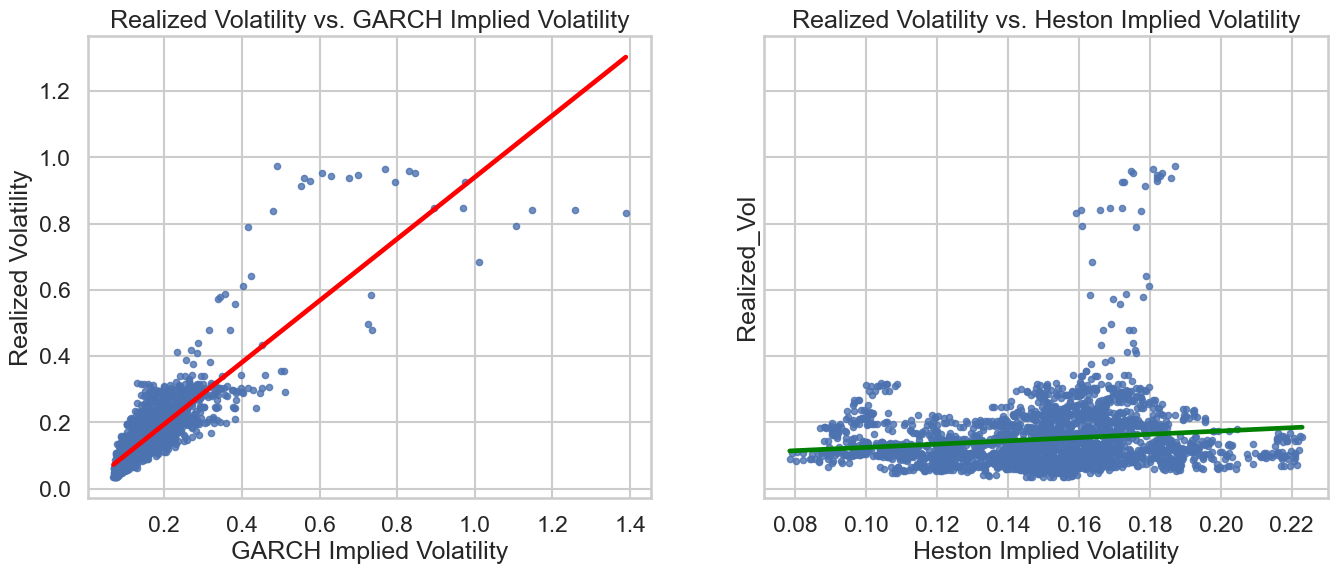

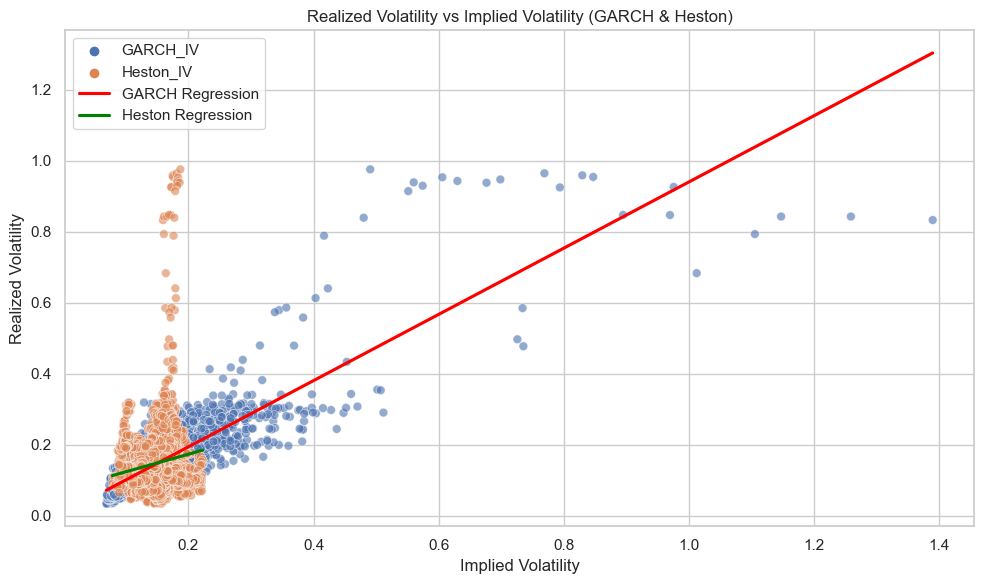

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn style for better visuals
sns.set(style='whitegrid', context='talk')

# 1. Scatter plot: Realized Vol vs GARCH and Heston IV with regression lines
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot 1: GARCH
sns.regplot(x='GARCH_IV', y='Realized_Vol', data=df_clean, ax=axes[0], scatter_kws={'s': 20}, line_kws={'color': 'red'},ci=None)
axes[0].set_title('Realized Volatility vs. GARCH Implied Volatility')
axes[0].set_xlabel('GARCH Implied Volatility')
axes[0].set_ylabel('Realized Volatility')

# Plot 2: Heston
sns.regplot(x='Heston_IV', y='Realized_Vol', data=df_clean, ax=axes[1], scatter_kws={'s': 20}, line_kws={'color': 'green'},ci=None)
axes[1].set_title('Realized Volatility vs. Heston Implied Volatility')
axes[1].set_xlabel('Heston Implied Volatility')


df_melted = df_clean.melt(id_vars='Realized_Vol', value_vars=['GARCH_IV', 'Heston_IV'],
                          var_name='Model', value_name='Implied_Vol')

sns.set(style='whitegrid', context='notebook')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_melted, x='Implied_Vol', y='Realized_Vol', hue='Model', alpha=0.6, s=40)
sns.regplot(data=df_melted[df_melted['Model'] == 'GARCH_IV'], 
            x='Implied_Vol', y='Realized_Vol', scatter=False, label='GARCH Regression', color='red',ci=None)
sns.regplot(data=df_melted[df_melted['Model'] == 'Heston_IV'], 
            x='Implied_Vol', y='Realized_Vol', scatter=False, label='Heston Regression', color='green',ci=None)

plt.title('Realized Volatility vs Implied Volatility (GARCH & Heston)')
plt.xlabel('Implied Volatility')
plt.ylabel('Realized Volatility')
plt.legend()
plt.tight_layout()
plt.show()


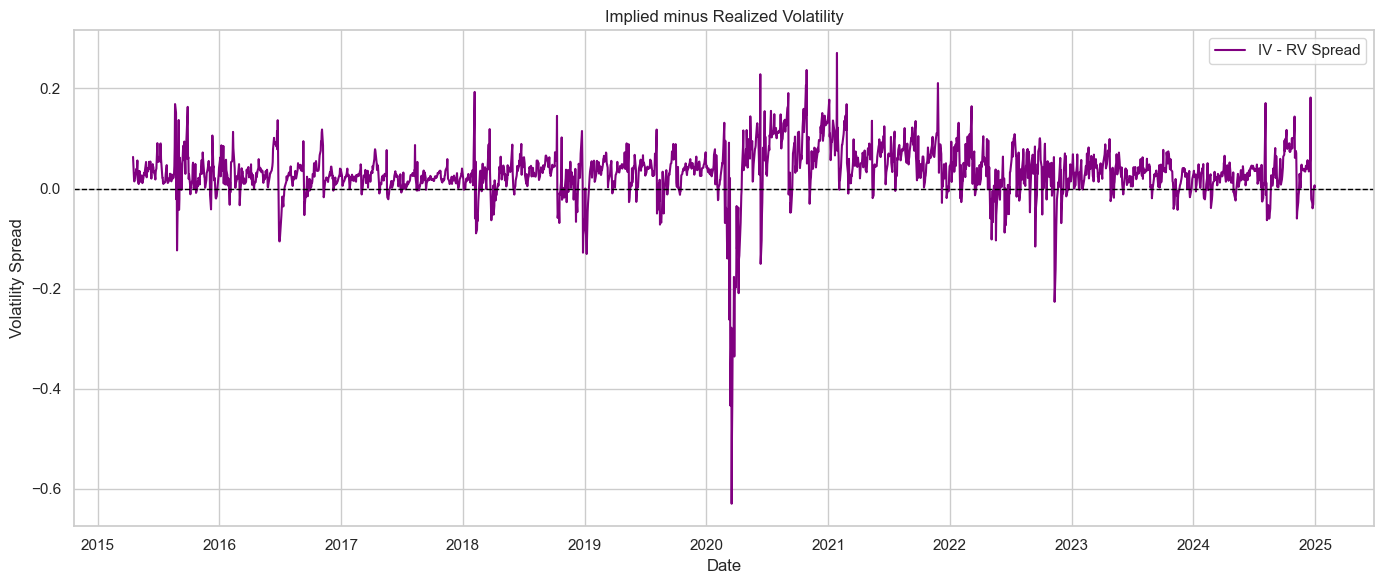

In [30]:
df.index = pd.to_datetime(df.index)

df['GARCH_IV'] = df['GARCH_Forecast']
df_clean = df[['Implied_Vol', 'GARCH_IV']].dropna()

df_clean['IV_minus_RV'] = df_clean['Implied_Vol'] - df_clean['GARCH_IV']

plt.figure(figsize=(14, 6))
plt.plot(df_clean.index, df_clean['IV_minus_RV'], label='IV - RV Spread', color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Implied minus Realized Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility Spread")
plt.legend()
plt.tight_layout()
plt.show()
